In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import pandas as pd
import re
import soundfile as sf

In [2]:
# Path to the folder containing LJSpeech wav files
audio_path = '/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1'

# Function to load audio and trim silence
def load_and_trim_audio(filename, target_sr=22050):
    audio, sr = librosa.load(filename, sr=target_sr)
    # Trim leading and trailing silence
    audio_trimmed, _ = librosa.effects.trim(audio)
    return audio_trimmed, sr

# Function to convert audio to Mel-spectrogram
def generate_mel_spectrogram(audio, sr):
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=80)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram

# Plot and save Mel-spectrogram
def plot_and_save_spectrogram(spectrogram, filename):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=22050, x_axis='time', y_axis='mel', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram')
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

# Process each audio file
for file in os.listdir(audio_path):
    if file.endswith('.wav'):
        audio_file = os.path.join(audio_path, file)
        audio_trimmed, sr = load_and_trim_audio(audio_file)
        mel_spectrogram = generate_mel_spectrogram(audio_trimmed, sr)
        plot_and_save_spectrogram(mel_spectrogram, f'spectrograms/{file[:-4]}.png')


In [3]:
# Load the transcripts.csv file
transcript_path = '/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/metadata.csv'
df = pd.read_csv(transcript_path, delimiter='|', header=None)
df.columns = ['ID', 'Transcription', 'Normalized Transcription']

# Function to clean text
# Function to clean text, handling NaN values
def clean_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters except for punctuation and alphanumeric characters
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    else:
        # If the text is not a string (i.e., NaN), return an empty string
        text = ''
    return text

# Apply text cleaning to the normalized transcription column
df['Cleaned Text'] = df['Normalized Transcription'].apply(clean_text)

# Tokenization (character-level)
def tokenize_text(text):
    return list(text)

# Tokenize the cleaned text
df['Tokenized Text'] = df['Cleaned Text'].apply(tokenize_text)

# Create a mapping of characters to numerical values (vocabulary)
vocab = sorted(set(''.join(df['Cleaned Text'].values)))
char_to_id = {char: idx for idx, char in enumerate(vocab)}

# Map tokens to numerical values
df['Token IDs'] = df['Tokenized Text'].apply(lambda tokens: [char_to_id[char] for char in tokens])

# Save the cleaned and tokenized text data
df.to_csv('cleaned_transcripts.csv', index=False)


In [4]:
# Path to the folder with audio files
audio_folder = '/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs'
target_sample_rate = 22050  # Target sampling rate

# Path to save resampled audio files
output_folder = '/kaggle/working/resampled_audio'
os.makedirs(output_folder, exist_ok=True)  # Create directory if it doesn't exist

def resample_audio(file_path, target_sample_rate):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=None)
    
    # Resample to the target sample rate
    if sr != target_sample_rate:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sample_rate)
    
    return audio, target_sample_rate

# Iterate through all audio files and resample them
for file in os.listdir(audio_folder):
    if file.endswith('.wav'):
        file_path = os.path.join(audio_folder, file)
        audio, sr = resample_audio(file_path, target_sample_rate)
        # Save the resampled audio to the working directory
        output_path = os.path.join(output_folder, file)
        sf.write(output_path, audio, sr)  # Save the resampled audio


In [5]:
def trim_silence(audio, threshold=0.001):
    # Trim leading and trailing silence with a lower threshold
    trimmed_audio, _ = librosa.effects.trim(audio, top_db=20)  # Adjust top_db to avoid over-trimming
    return trimmed_audio

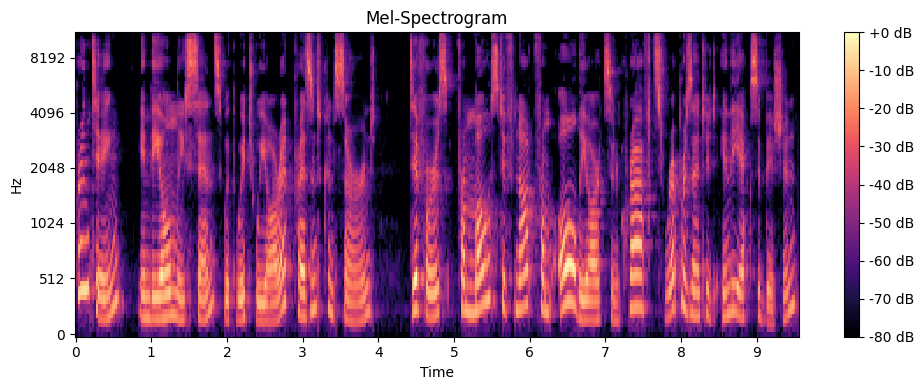

In [6]:
# Function to generate mel-spectrogram
def generate_mel_spectrogram(audio, sample_rate, n_mels=80, n_fft=512):
    # Compute mel-spectrogram with smaller FFT size
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels, n_fft=n_fft)
    
    # Convert to dB for visualization
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

# Example: Load an audio file (replace 'example.wav' with your actual file path)
audio_path = '/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ001-0001.wav'
audio, sample_rate = librosa.load(audio_path, sr=22050)

# Trim silence
trimmed_audio = trim_silence(audio)

# Generate mel-spectrogram
mel_spec = generate_mel_spectrogram(trimmed_audio, sample_rate)

# Plot the mel-spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()

In [7]:
from IPython.display import Audio
Audio(audio, rate=target_sample_rate)


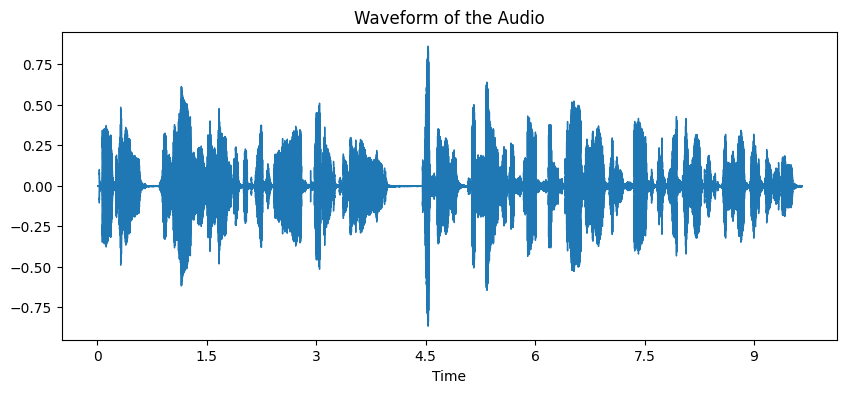

In [8]:
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=target_sample_rate)
plt.title('Waveform of the Audio')
plt.show()


In [9]:
trimmed_audio, _ = librosa.effects.trim(audio, top_db=30)


In [10]:
mel_spectrogram = librosa.feature.melspectrogram(
    y=audio, 
    sr=target_sample_rate, 
    n_fft=1024,   # Experiment with this value
    hop_length=256,   # Adjust hop length for time resolution
    n_mels=80        # Default is good, but you can adjust
)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)


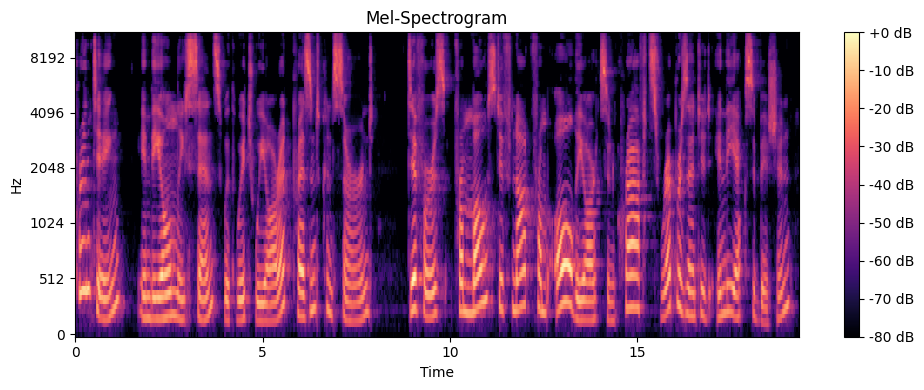

In [11]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=target_sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()
